### Импортируем библиотечки

In [1]:
%%capture
!pip install transformers torchmetrics focal_loss_torch opencv-python gdown optuna

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.1 is successfully installed


In [3]:
%cd

/home/innodatahub


In [ ]:
!pip install gdown
!gdown 13X6J0enOo1m-MCbUvMt-lueWrdGXNnF0
!gdown 1HJqqXsw9OnM3nSRgAcqNy5ktqnqWPtfq
!gdown 1fkx3Hq0j0ItDz0z-OX36pAqFJ3k21NGm

In [28]:
import pandas as pd
import cv2
import os
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import optuna

from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification
from collections import OrderedDict
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [5]:
torch.cuda.is_available()

True

In [6]:
def display_image(img):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_axis_off()
    plt.show()

### Определяем аугментации

In [19]:
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.RandomCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

valid_transform = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.CenterCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

### Определяем датасет

In [72]:
#сперва обработаем картинки
label2id = ["Развлечения и юмор", "Кулинария", "Торговля и объявления", "СМИ", "Философия и религия", "Животные", "Творчество и дизайн", "Путешествия"]
class make_dataset_(Dataset):
  def __init__(self, data_df, path_to_data, transform, mode="train"):
    self.path_to_data = path_to_data
    self.data = data_df.copy()
    self.data["id"] = self.data["id"].apply(lambda x: os.path.join(path_to_data, str(x)))
    self.mode = mode
    self.transform = transform
  def __getitem__(self, id):
    to_tensor = ToTensorV2()
    img = cv2.imread(self.data.iloc[id, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.transform(image=img)["image"]
    img = to_tensor(image=cv2.resize(img, (224, 224)))["image"].to(torch.float32)
    if self.mode == "train":
      label = self.data.iloc[id, 2]
      return img, label2id.index(label)
    else:
      return img,
  def __len__(self):
    return len(self.data)

### Создаём датасет, сплитим, смотрим на распределение классов

In [73]:
data = pd.read_csv("work/text_image_data/image_train.csv", sep=";")
data = data[data.label.isin(label2id)]
data.index = list(range(0, data.shape[0]))

train_df, valid_df = train_test_split(data, test_size=0.15, train_size=0.85)
valid_df.index = [i for i in range(len(valid_df))]
train_dset = make_dataset_(train_df, "work/text_image_data/data/Train", train_transform)
valid_dset = make_dataset_(valid_df, "work/text_image_data/data/Train", valid_transform)

In [74]:
len(train_dset), len(valid_dset)

(4204, 743)

<Axes: ylabel='Train'>

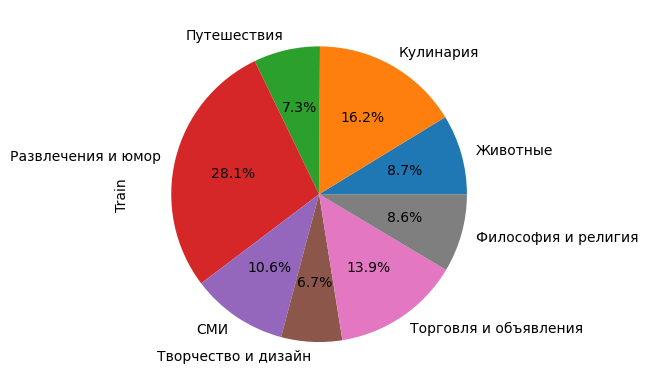

In [30]:
train_df.groupby("label").size().plot(kind='pie',
                                   y = "label",
                                   label = "Train",
                                   autopct='%1.1f%%')

<Axes: ylabel='Validation'>

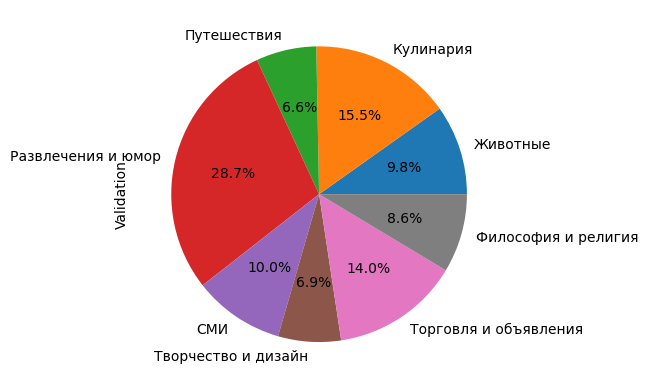

In [31]:
valid_df.groupby("label").size().plot(kind='pie',
                                   y = "label",
                                   label = "Validation",
                                   autopct='%1.1f%%')

### Смотрим на аугментации

In [75]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1, 2, 0))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


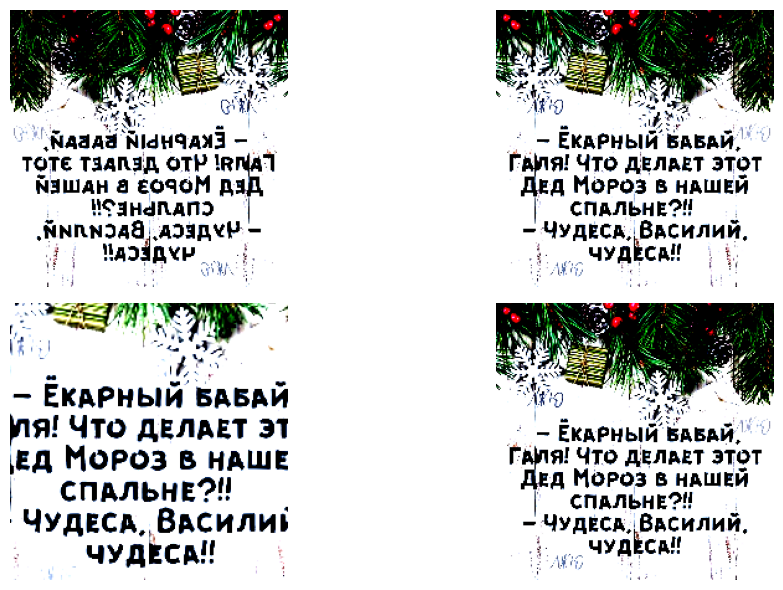

In [77]:
visualize_augmentations(train_dset, idx=946, samples=4, cols=2)

### Определяем класс для подсчёта метрик

In [41]:
def calculate_accuracy(output, target):
    train_accuracy = torch.sum(target == output) / len(target)
    return train_accuracy

def calculate_f1(output, target):
    return f1_score(target.cpu(), output.cpu(), average="macro")

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Фунцкия для создания модели

In [96]:
best_model = None
model_image = None

In [104]:
def create_model(trial):
    global model_image
    
    model_image = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")
    
    ln_middle_feat = trial.suggest_int("linear_middle_feat", 512, 800)
    model_image.classifier = nn.Sequential(OrderedDict([
        ("ln1", nn.Linear(1280, ln_middle_feat, bias=True)),
        ("dp2", nn.ReLU()),
        ("ln2", nn.Linear(ln_middle_feat, 8, bias=True)),
        ("act2", nn.ReLU()),
    ]))
    
    for p in model_image.parameters():
        p.requires_grad = False
    
    count_of_unfrozen = trial.suggest_int("count_of_unfrozen", 1, 16)
    for i in range(16 - count_of_unfrozen, 16):
      for p in getattr(model_image.efficientnet.encoder.blocks, str(i)).parameters():
        p.requires_grad = True
    
    was_true = 0
    for p in model_image.parameters():
      if p.requires_grad == False and was_true == 0: continue
      elif p.requires_grad == True:
        was_true = 1
      else: p.requires_grad = True
    return model_image

### Функции трейна и валидации 

In [105]:
# from sklearn.metrics import f1_score
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor(float_precision=4)
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(images)["logits"]
        output = torch.nn.functional.softmax(output, dim=1)
        loss = criterion(output, target)
        output = torch.argmax(output, dim=1).to(torch.int64)
        accuracy = calculate_accuracy(output, target)
        f1 = calculate_f1(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        metric_monitor.update("F1", f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [99]:
def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor(float_precision=4)
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(images)["logits"]
            output = torch.nn.functional.softmax(output, dim=1)
            loss = criterion(output, target)
            output = torch.argmax(output, dim=1).to(torch.int64)
            accuracy = calculate_accuracy(output, target)
            f1 = calculate_f1(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1", f1)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics["F1"]["avg"], metric_monitor.metrics["Accuracy"]["avg"]

### Objective Функция

In [115]:
def objective(trial):
    lr_base = trial.suggest_categorical("lr_base", [2e-4, 3e-4, 2e-5])
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "Adagrad", "RMSprop"])
    
    device = torch.device("cuda")
    model = create_model(trial).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr_base)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    train_loader = DataLoader(
        train_dset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True,
    )
    val_loader = DataLoader(
        valid_dset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True,
    )
    
    for epoch in range(1, 21):
        train(train_loader, model, criterion, optimizer, epoch, device)
        f1, acc = validate(val_loader, model, criterion, epoch, device)
        
        scheduler.step(acc)

        trial.report(f1, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return f1

### Оптимизируем модель

In [ ]:
import time
from IPython.display import clear_output

num_epochs = 1

def callback(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model_image

def clean_stream(study, trial):
    global num_epochs
    clear_output(wait=True)
    num_epochs += 1
    print(num_epochs)

start_time = time.time()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[callback, clean_stream])

end_time = time.time()
took_time =  end_time - start_time

3


Epoch: 1. Train.      Loss: 1.9579 | Accuracy: 0.4411 | F1: 0.2541: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s]
Epoch: 1. Validation. Loss: 1.8879 | Accuracy: 0.4620 | F1: 0.2991: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]
Epoch: 2. Train.      Loss: 1.8459 | Accuracy: 0.5219 | F1: 0.3505: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s]
Epoch: 2. Validation. Loss: 1.8418 | Accuracy: 0.5604 | F1: 0.3970: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]
Epoch: 3. Train.      Loss: 1.8187 | Accuracy: 0.5393 | F1: 0.3685: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s]
Epoch: 3. Validation. Loss: 1.8231 | Accuracy: 0.5465 | F1: 0.3843: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]
Epoch: 4. Train.      Loss: 1.7976 | Accuracy: 0.5533 | F1: 0.3869: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s]
Epoch: 4. Validation. Loss: 1.8052 | Accuracy: 0.5501 | F1: 0.3766: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
Epoch: 5. Train.      Loss: 1.7855 | Accuracy: 0.5753 | F1: 0.4064: 100%

In [ ]:
print(f"This took {took_time // 60} minutes and {took_time - (took_time // 60)} seconds")
print()
print("best trial: ", study.best_trial)
print()
print("best_score: ", study.best_value)
print()
print("best_params: ", study.best_params)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()